In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [2]:
import os 
os.environ['OMP_NUM_THREADS'] = '7'

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:



# Load dataset
data = pd.read_csv('Input_data/cpa_preprocessed.csv')

# Drop target variable
features = data.drop(columns=['NumStorePurchases'])



In [5]:
# # Set default font size for all plots
# plt.rcParams.update({
#     'font.size': 18,
#     'axes.titlesize': 18,
#     'axes.labelsize': 18,
#     'xtick.labelsize': 16,
#     'ytick.labelsize': 16,
#     'legend.fontsize': 18,
#     'figure.titlesize': 22
# })

In [6]:

# Normalize the data
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

# Split into training and test sets
X_train, X_test = train_test_split(normalized_features, test_size=0.2, random_state=30)


In [7]:

# Determine optimal number of clusters using Elbow Method and Silhouette Score
inertia = []
silhouette_scores = []
k_values = range(2, 50)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=30, n_init=15)
    kmeans.fit(X_train)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train, kmeans.labels_))


<Figure size 1000x400 with 0 Axes>

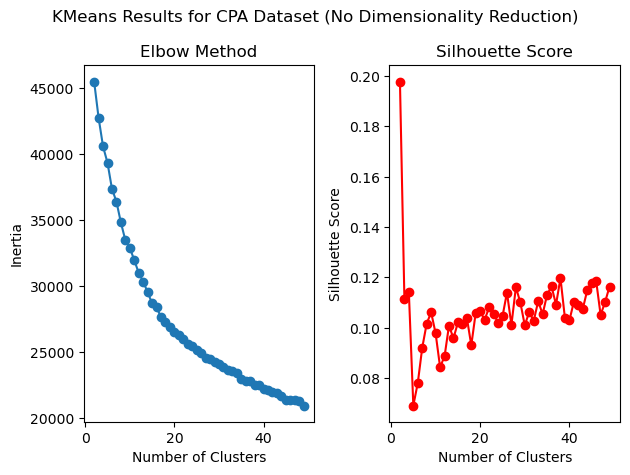

In [8]:

# Plot Elbow Method
plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1)
fig1, axs = plt.subplots(1, 2)
fig1.suptitle('KMeans Results for CPA Dataset (No Dimensionality Reduction)')

axs[0].plot(k_values, inertia, marker='o')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Inertia')
axs[0].set_title('Elbow Method')
# axs[0].set_xticks(k_values)

# Plot Silhouette Scores
# plt.subplot(1, 2, 2)
axs[1].plot(k_values, silhouette_scores, marker='o', color='red')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Silhouette Score')
axs[1].set_title('Silhouette Score')
# axs[1].set_xticks(k_values)
plt.tight_layout()



# fig1.tight_layout()
# fig1.subplots_adjust(top=0.88)
plt.show()


In [9]:


# Optimal number of clusters (choosing the best from both methods)
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f'Optimal number of clusters: {optimal_k}')

# Apply KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=30, n_init=10)
kmeans_labels = kmeans.fit_predict(X_train)

# Apply Expectation Maximization (Gaussian Mixture Model)
gmm = GaussianMixture(n_components=optimal_k, random_state=30)
gmm_labels = gmm.fit_predict(X_train)


Optimal number of clusters: 2


In [10]:


# Evaluate clustering performance
kmeans_silhouette = silhouette_score(X_train, kmeans_labels)
kmeans_db = davies_bouldin_score(X_train, kmeans_labels)

gmm_silhouette = silhouette_score(X_train, gmm_labels)
gmm_db = davies_bouldin_score(X_train, gmm_labels)
gmm_log_likelihood = gmm.score(X_train)

print(f'KMeans - Silhouette Score: {kmeans_silhouette}, Davies-Bouldin Index: {kmeans_db}')
print(f'GMM - Silhouette Score: {gmm_silhouette}, Davies-Bouldin Index: {gmm_db}, Log-Likelihood: {gmm_log_likelihood}')



KMeans - Silhouette Score: 0.19783796310798993, Davies-Bouldin Index: 2.1793583731568296
GMM - Silhouette Score: 0.28914339912298587, Davies-Bouldin Index: 2.4610470669446647, Log-Likelihood: -9.705806698511083


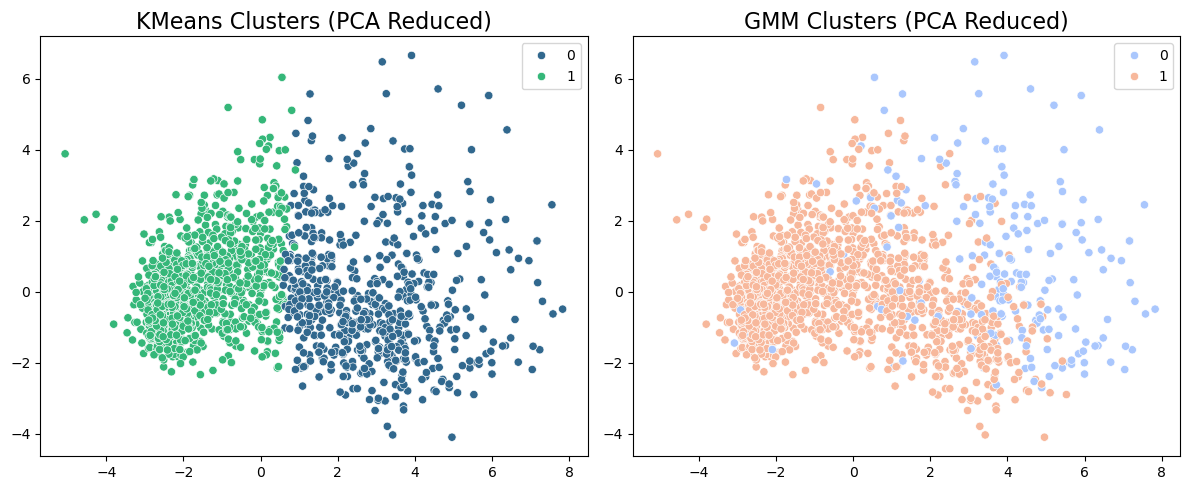

In [11]:

# Visualize clusters using PCA (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis')
plt.title('KMeans Clusters (PCA Reduced)', fontsize=16)

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=gmm_labels, palette='coolwarm')
plt.title('GMM Clusters (PCA Reduced)', fontsize=16)
plt.tight_layout()
plt.show()


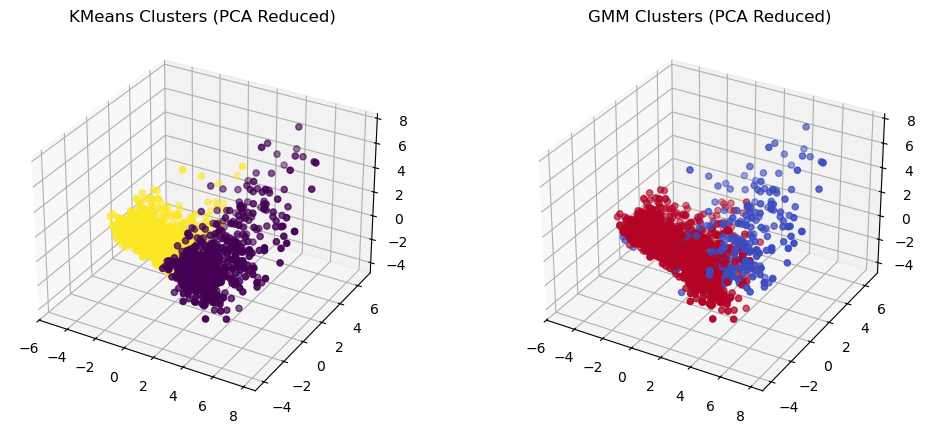

In [12]:

# Visualize clusters using PCA (3D)
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_train)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=kmeans_labels, cmap='viridis')
ax.set_title('KMeans Clusters (PCA Reduced)')

ax = fig.add_subplot(122, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=gmm_labels, cmap='coolwarm')
ax.set_title('GMM Clusters (PCA Reduced)')

plt.show()


#### Finding ideal number of clusters using GMM for CPA


In [13]:
# Determine optimal number of clusters using GMM (BIC/AIC)
bic_scores = []
aic_scores = []

# cpa_gmm_inertia = []
# cpa_gmm_silhouette_scores =[]

k_values = range(2, 50)
log_likelihoods = []

for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=30)
    gmm.fit(X_train)
    bic_scores.append(gmm.bic(X_train))
    aic_scores.append(gmm.aic(X_train))
    log_likelihoods.append(gmm.score(X_train))
    # cpa_gmm_inertia.append(gmm.inertia_)
    # cpa_gmm_silhouette_scores.append(silhouette_score(X_train, gmm.labels_))


## there is no straight forward way to calculate intertia or silhouette score for GMM
## so we will use BIC and AIC scores to determine the optimal number of clusters


    


In [14]:
# Create DataFrame for BIC, AIC, and Log-Likelihood
scores_df = pd.DataFrame({'Clusters': k_values, 'BIC': bic_scores, 'AIC': aic_scores, 'Log-Likelihood': log_likelihoods})
print(scores_df)

    Clusters           BIC            AIC  Log-Likelihood
0          2  42209.279013   36767.611207       -9.705807
1          3  37271.491226   29106.243974       -7.291363
2          4   3899.680675   -6989.146023        3.056681
3          5  -4617.849809  -18230.255953        6.469937
4          6 -20482.328196  -36818.313787       11.933123
5          7 -27138.008970  -46197.574007       14.826890
6          8 -39233.991817  -61017.136301       19.238598
7          9 -33351.222858  -57857.946788       18.633914
8         10 -41194.999348  -68425.302725       21.859180
9         11 -41490.714753  -71444.597576       22.978403
10        12 -42034.400655  -74711.862925       24.166814
11        13 -48469.834366  -83870.876082       26.999128
12        14 -59240.120605  -97364.741767       31.040944
13        15 -58831.604192  -99679.804800       31.963673
14        16 -60497.455331 -104069.235385       33.465188
15        17 -55523.799317 -101819.158818       33.114163
16        18 -

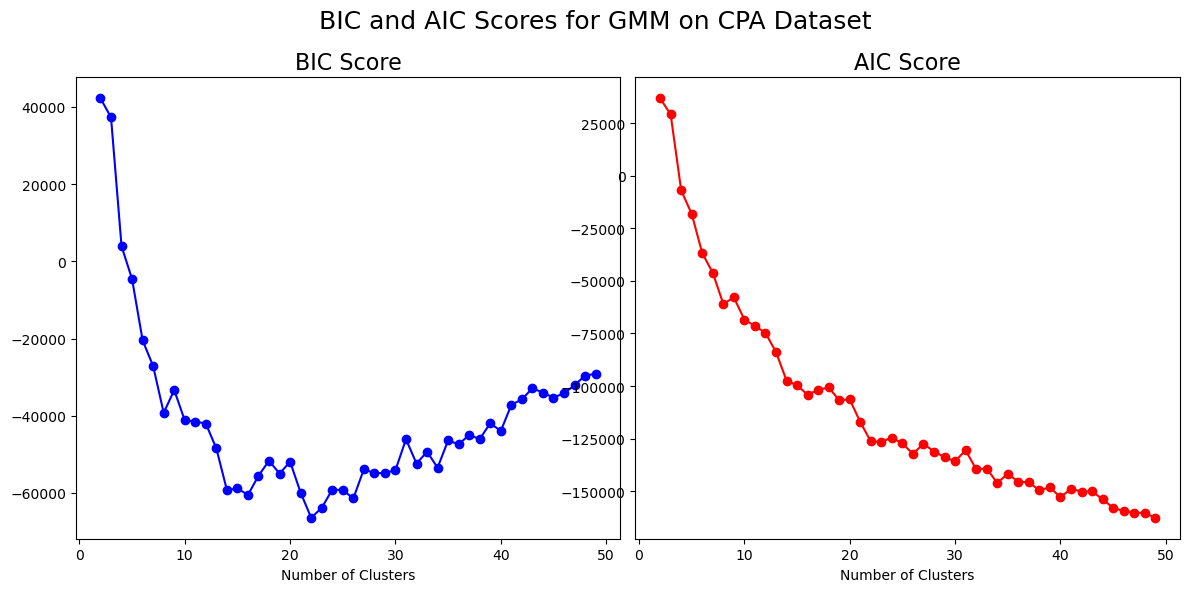

In [15]:

# Plot BIC and AIC Scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.suptitle('BIC and AIC Scores for GMM on CPA Dataset', fontsize=18)
plt.plot(k_values, bic_scores, marker='o', color='blue')
plt.xlabel('Number of Clusters')
# plt.ylabel('BIC Score')
plt.title('BIC Score', fontsize=16)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(k_values, aic_scores, marker='o', color='red')
plt.xlabel('Number of Clusters')
# plt.ylabel('AIC Score')
plt.title('AIC Score', fontsize=16)

plt.show()


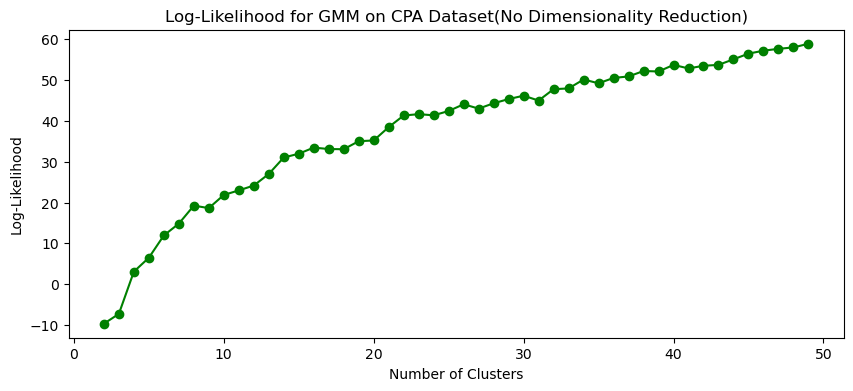

In [16]:


# Plot Log-Likelihood
plt.figure(figsize=(10, 4)) 
plt.plot(k_values, log_likelihoods, marker='o', color='green')
plt.xlabel('Number of Clusters')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood for GMM on CPA Dataset(No Dimensionality Reduction)') 
plt.show()         

In [17]:

# Optimal number of clusters (choosing the best from BIC)
optimal_k = k_values[bic_scores.index(min(bic_scores))]
print(f'Optimal number of clusters (GMM - BIC): {optimal_k}')

# Apply Expectation Maximization (Gaussian Mixture Model)
gmm = GaussianMixture(n_components=optimal_k, random_state=30)
gmm_labels = gmm.fit_predict(X_train)

# Evaluate clustering performance
gmm_silhouette = silhouette_score(X_train, gmm_labels)
gmm_db = davies_bouldin_score(X_train, gmm_labels)
gmm_log_likelihood = gmm.score(X_train)

print(f'GMM - Silhouette Score: {gmm_silhouette}, Davies-Bouldin Index: {gmm_db}, Log-Likelihood: {gmm_log_likelihood}')


####

#For the "optimal" k means clustering of size 2, here were the results for silhoutee score
#KMeans - Silhouette Score: 0.19783796310798993, Davies-Bouldin Index: 2.1793583731568296
#GMM - Silhouette Score: 0.28914339912298587, Davies-Bouldin Index: 2.4610470669446647, Log-Likelihood: -9.705806698511083

####

Optimal number of clusters (GMM - BIC): 22
GMM - Silhouette Score: 0.10213119150657489, Davies-Bouldin Index: 2.2228527042750112, Log-Likelihood: 41.33670830265562


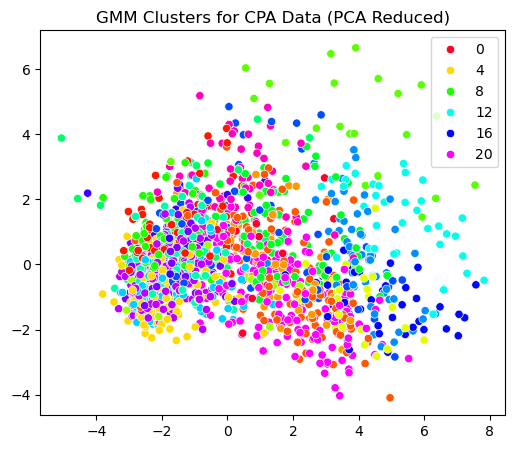

In [18]:

# Visualize clusters using PCA (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=gmm_labels, palette='gist_rainbow')
plt.title('GMM Clusters for CPA Data (PCA Reduced)')
plt.show()


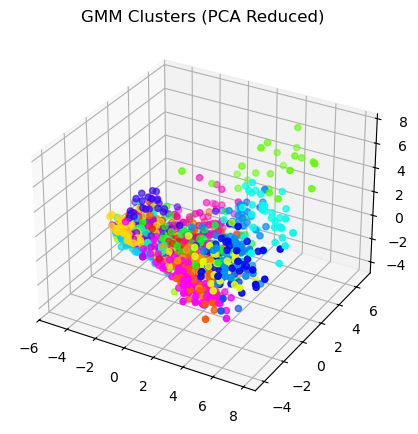

In [19]:

# Visualize clusters using PCA (3D)
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_train)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=gmm_labels, cmap='gist_rainbow')
ax.set_title('GMM Clusters (PCA Reduced)')

plt.show()


##### CPA Results

Findings from the GMM work on CPA:

Basically looking at the optimum results for KMeans we get the following score.

KMeans - Silhouette Score: 0.19783796310798993, Davies-Bouldin Index: 2.1793583731568296
GMM - Silhouette Score: 0.28914339912298587, Davies-Bouldin Index: 2.4610470669446647, Log-Likelihood: -9.705806698511083


When we compare it to the "best results" for GMM using BIC and AIC, we see that the silhouette score and davies-bouldin index are sitll higher for 2 groups rather than the higher grouping that GMM calls for.


We also see that GMM continues to produce "better and better" AIC and BIC scores as we increase the number of groups, even though it doesn't lead to better Silhouette Score or Davies-Bouldin Index.


#### Spotify Data


In [20]:
# Load dataset
spotify_data = pd.read_csv('Input_data/spotify_processed.csv')


In [21]:
spotify_data.head()

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,popularity
0,2,2023,7,14,553,147,141381703.0,43,263,45,...,B,Major,80,89,83,31,0,8,4,0
1,1,2023,3,23,1474,48,133716286.0,48,126,58,...,C#,Major,71,61,74,7,0,10,4,0
2,1,2023,6,30,1397,113,140003974.0,94,207,91,...,F,Major,51,32,53,17,0,31,6,0
3,1,2019,8,23,7858,100,800840817.0,116,207,125,...,A,Major,55,58,72,11,0,11,15,1
4,1,2023,5,18,3133,50,303236322.0,84,133,87,...,A,Minor,65,23,80,14,63,11,6,1


In [22]:
# Replace NaN values in the 'in_shazam_charts' column with its median
spotify_data['in_shazam_charts'] = spotify_data['in_shazam_charts'].fillna(spotify_data['in_shazam_charts'].median())

# Verify that there are no more NaN values in the 'in_shazam_charts' column
nan_counts_after = spotify_data['in_shazam_charts'].isnull().sum()
print(f"NaN values in 'in_shazam_charts' after replacement: {nan_counts_after}")


NaN values in 'in_shazam_charts' after replacement: 0


In [23]:
# Identify NaN values in 'key' and 'mode' columns
print("NaN values before imputation:")
print(spotify_data[['key', 'mode']].isnull().sum())

# Fill NaN values with most frequent value for each column
spotify_data['key'] = spotify_data['key'].fillna(spotify_data['key'].mode()[0])
spotify_data['mode'] = spotify_data['mode'].fillna(spotify_data['mode'].mode()[0])

# Verify that there are no more NaN values
print("\nNaN values after imputation:")
print(spotify_data[['key', 'mode']].isnull().sum())

NaN values before imputation:
key     95
mode     0
dtype: int64

NaN values after imputation:
key     0
mode    0
dtype: int64


In [ ]:
# ###Exporting cleaned up version of the spotify dataset

# spotify_data.to_csv('cleaned_spotify_data.csv', index=False)

In [24]:
spotify_features = spotify_data.drop(columns=['popularity'])

In [25]:
##Not using key or mode since I did not use those variables in Assignment 1

features = ['bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 
            'instrumentalness_%', 'liveness_%', 'speechiness_%', 'in_spotify_playlists', 
            'in_deezer_playlists', 'in_apple_playlists','artist_count', 'released_year']

In [26]:
spotify_features_encoded = spotify_features[features]

In [27]:
spotify_features_encoded.head()

,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,in_spotify_playlists,in_deezer_playlists,in_apple_playlists,artist_count,released_year
0,125,80,89,83,31,0,8,4,553,45,43,2,2023
1,92,71,61,74,7,0,10,4,1474,58,48,1,2023
2,138,51,32,53,17,0,31,6,1397,91,94,1,2023
3,170,55,58,72,11,0,11,15,7858,125,116,1,2019
4,144,65,23,80,14,63,11,6,3133,87,84,1,2023


In [28]:
spotify_features_encoded.describe()

,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,in_spotify_playlists,in_deezer_playlists,in_apple_playlists,artist_count,released_year
count,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000
mean,122.553571,66.984244,51.406513,64.274160,27.078782,1.582983,18.214286,10.138655,5202.565126,385.535714,67.866597,1.556723,2018.288866
std,28.069601,14.631282,23.480526,16.558517,26.001599,8.414064,13.718374,9.915399,7901.400683,1131.078760,86.470591,0.893331,11.011397
min,65.000000,23.000000,4.000000,9.000000,0.000000,0.000000,3.000000,2.000000,31.000000,0.000000,0.000000,1.000000,1930.000000
25%,99.750000,57.000000,32.000000,53.000000,6.000000,0.000000,10.000000,4.000000,874.500000,13.000000,13.000000,1.000000,2020.000000
50%,121.000000,69.000000,51.000000,66.000000,18.000000,0.000000,12.000000,6.000000,2216.500000,44.000000,34.000000,1.000000,2022.000000
75%,140.250000,78.000000,70.000000,77.000000,43.000000,0.000000,24.000000,11.000000,5573.750000,164.250000,88.000000,2.000000,2022.000000
max,206.000000,96.000000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000,52898.000000,12367.000000,672.000000,8.000000,2023.000000


In [29]:

# Normalize the data
spotify_scalar = StandardScaler()
normalized_features = spotify_scalar.fit_transform(spotify_features_encoded)

# Split into training and test sets
X_train_spotify, X_test_spotify = train_test_split(normalized_features, test_size=0.2, random_state=30)


In [30]:

# Determine optimal number of clusters using Elbow Method and Silhouette Score
inertia_spotify = []
silhouette_scores_spotify = []



In [31]:

k_values = range(2, 50)

for k in k_values:
    kmeans_spotify = KMeans(n_clusters=k, random_state=30, n_init=10)
    kmeans_spotify.fit(X_train_spotify)
    inertia_spotify.append(kmeans_spotify.inertia_)
    silhouette_scores_spotify.append(silhouette_score(X_train_spotify, kmeans_spotify.labels_))


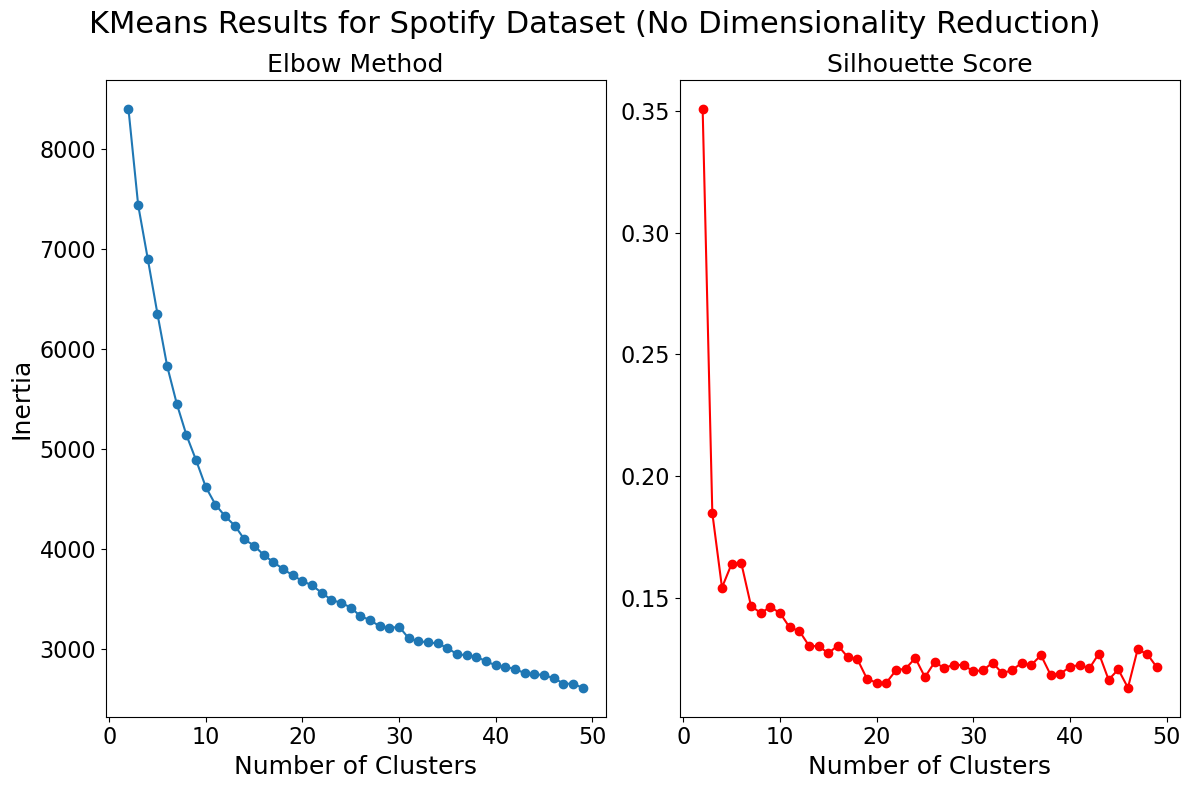

In [32]:

# Plot Elbow Method
plt.figure(figsize=(12, 8))
plt.suptitle('KMeans Results for Spotify Dataset (No Dimensionality Reduction)', fontsize= 22)

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia_spotify, marker='o')
plt.xlabel('Number of Clusters',fontsize= 18)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.ylabel('Inertia', fontsize= 18)
plt.title('Elbow Method', fontsize= 18)
plt.tight_layout()

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores_spotify, marker='o', color='red')
plt.xlabel('Number of Clusters', fontsize= 18)
# plt.ylabel('Silhouette Score')
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.title('Silhouette Score',fontsize= 18)
plt.tight_layout()

plt.show()


In [33]:

# Optimal number of clusters (choosing the best from both methods)
optimal_k = k_values[silhouette_scores_spotify.index(max(silhouette_scores_spotify))]
print(f'Optimal number of clusters: {optimal_k}')

# Apply KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=30, n_init=10)
spotify_kmeans_labels = kmeans.fit_predict(X_train_spotify)

# Apply Expectation Maximization (Gaussian Mixture Model)
gmm = GaussianMixture(n_components=optimal_k, random_state=30)
spotify_gmm_labels = gmm.fit_predict(X_train_spotify)

# Evaluate clustering performance
kmeans_silhouette = silhouette_score(X_train_spotify, spotify_kmeans_labels)
kmeans_db = davies_bouldin_score(X_train_spotify, spotify_kmeans_labels)

gmm_silhouette = silhouette_score(X_train_spotify, spotify_gmm_labels)
gmm_db = davies_bouldin_score(X_train_spotify, spotify_gmm_labels)
gmm_log_likelihood = gmm.score(X_train_spotify)

print(f'KMeans - Silhouette Score: {kmeans_silhouette}, Davies-Bouldin Index: {kmeans_db}')
print(f'GMM - Silhouette Score: {gmm_silhouette}, Davies-Bouldin Index: {gmm_db}, Log-Likelihood: {gmm_log_likelihood}')


Optimal number of clusters: 2
KMeans - Silhouette Score: 0.3506936467060824, Davies-Bouldin Index: 1.6637912136841646
GMM - Silhouette Score: 0.1674021580326207, Davies-Bouldin Index: 2.4677062263191503, Log-Likelihood: -12.482407106324839


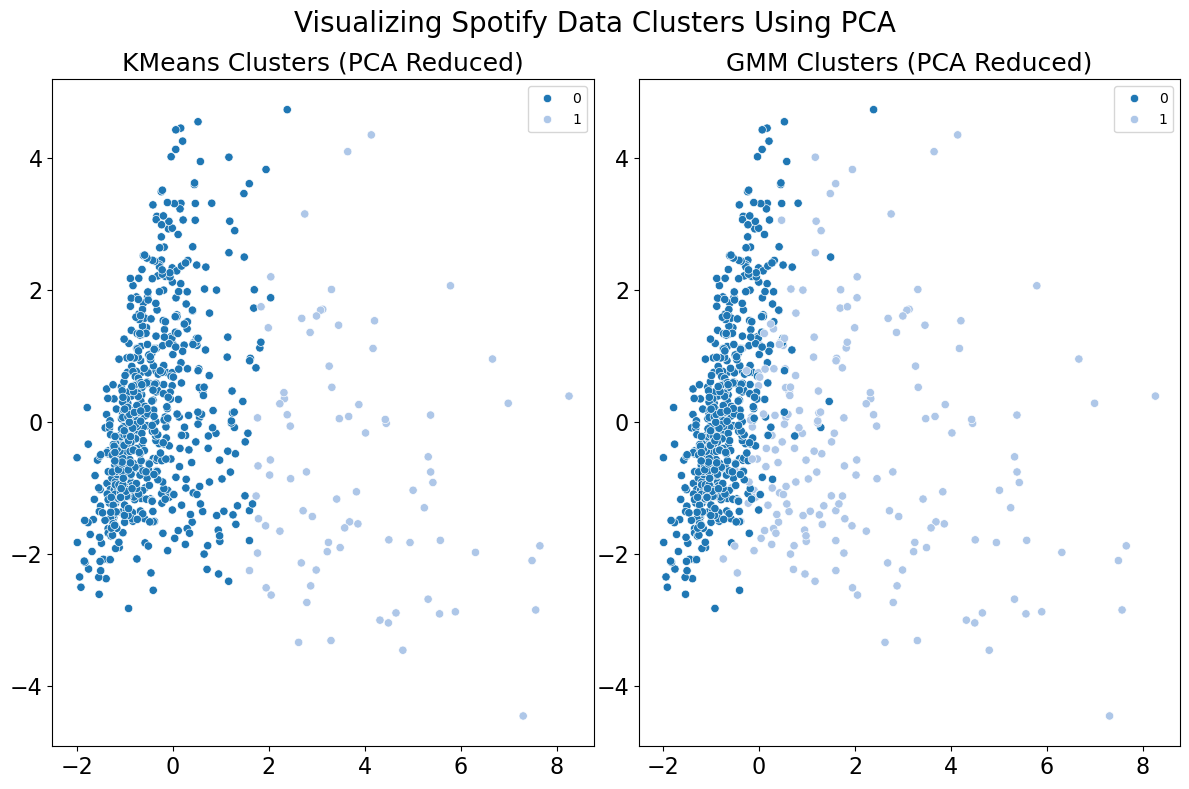

In [34]:

# Visualize clusters using PCA (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_spotify)

plt.figure(figsize=(12, 8))
plt.suptitle('Visualizing Spotify Data Clusters Using PCA', fontsize= 20)

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=spotify_kmeans_labels, palette='tab20')
plt.title('KMeans Clusters (PCA Reduced)', fontsize= 18)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
# plt.tight_layout()


plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=spotify_gmm_labels, palette='tab20')
plt.title('GMM Clusters (PCA Reduced)', fontsize= 18)
plt.tight_layout()
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)

plt.show()


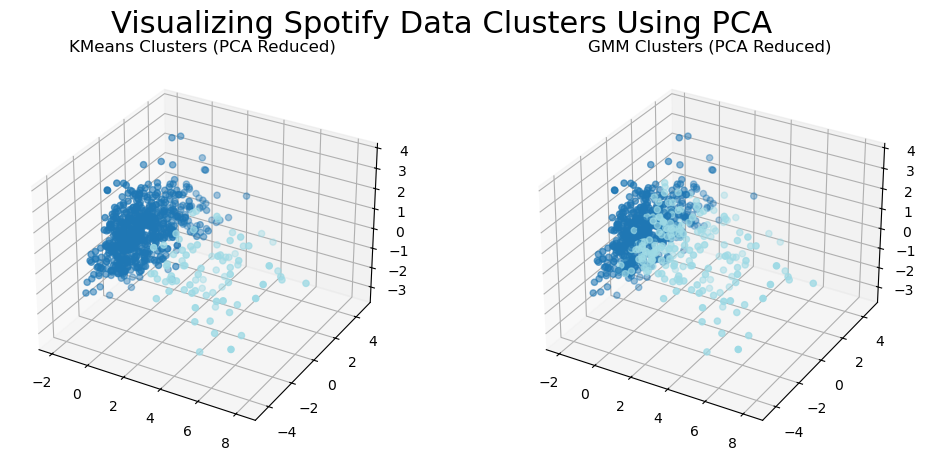

In [35]:

# Visualize clusters using PCA (3D)
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_train_spotify)

fig = plt.figure(figsize=(12, 5))
plt.suptitle('Visualizing Spotify Data Clusters Using PCA', fontsize= 22)

ax = fig.add_subplot(121, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=spotify_kmeans_labels, cmap='tab20')
ax.set_title('KMeans Clusters (PCA Reduced)')

ax = fig.add_subplot(122, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=spotify_gmm_labels, cmap='tab20')
ax.set_title('GMM Clusters (PCA Reduced)')

plt.show()



#### (Spotify) Attempting to find optimal clusters using GMM 

In [36]:
# Determine optimal number of clusters using GMM (BIC/AIC)
spotify_bic_scores = []
spotify_aic_scores = []
spotify_log_likelihoods = []
k_values = range(2, 50)

for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=30)
    gmm.fit(X_train_spotify)
    spotify_bic_scores.append(gmm.bic(X_train_spotify))
    spotify_aic_scores.append(gmm.aic(X_train_spotify))
    spotify_log_likelihoods.append(gmm.score(X_train_spotify))

# Create DataFrame for BIC, AIC, and Log-Likelihood
spotify_scores_df = pd.DataFrame({'Clusters': k_values, 'BIC': spotify_bic_scores, 'AIC': spotify_aic_scores, 'Log-Likelihood': spotify_log_likelihoods})
print(spotify_scores_df)


    Clusters           BIC           AIC  Log-Likelihood
0          2  20384.861988  19416.223616      -12.482407
1          3  12317.450235  10862.175360       -6.724163
2          4  11212.907411   9270.996034       -5.540733
3          5  11513.609614   9085.061734       -5.280592
4          6   9300.355439   6385.171057       -3.368706
5          7  12236.617914   8834.797029       -4.840208
6          8  12178.458154   8290.000767       -4.344284
7          9  11502.330836   7127.236946       -3.442337
8         10  11858.640769   6996.910376       -3.218732
9         11  11650.204328   6301.837433       -2.624072
10        12  13135.826843   7300.823445       -3.142460
11        13  13557.222224   7235.582324       -2.961618
12        14  13731.188776   6922.912373       -2.618208
13        15  14225.568254   6930.655349       -2.485319
14        16  14170.935473   6389.386065       -1.991712
15        17  14838.074388   6569.888478       -1.972331
16        18  14647.478629   58

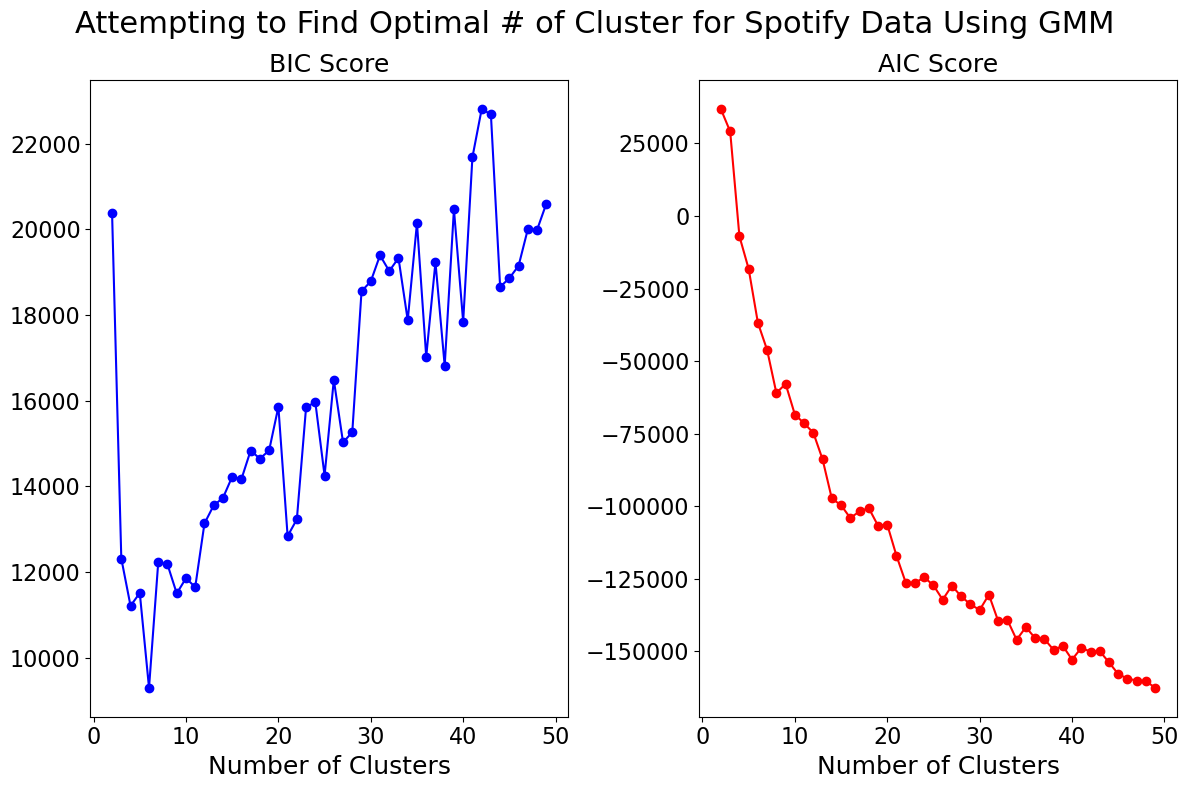

In [37]:

# Plot BIC and AIC Scores
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.suptitle('Attempting to Find Optimal # of Cluster for Spotify Data Using GMM', fontsize= 22)

plt.plot(k_values, spotify_bic_scores, marker='o', color='blue')
plt.xlabel('Number of Clusters', fontsize= 18)
# plt.ylabel('BIC Score', fontsize= 18)
plt.title('BIC Score', fontsize= 18)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
# plt.title('BIC Score for GMM on Spotify Data')

plt.subplot(1, 2, 2)
plt.plot(k_values, aic_scores, marker='o', color='red')
plt.xlabel('Number of Clusters', fontsize= 18)
# plt.ylabel('AIC Score', fontsize= 18)
plt.title('AIC Score', fontsize= 18)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.tight_layout()  

# plt.title('AIC Score for GMM on Spotify Data')
plt.show()


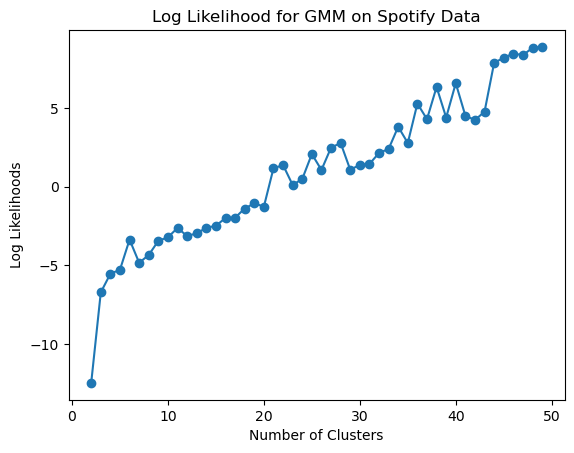

In [38]:

plt.plot(k_values, spotify_log_likelihoods, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Log Likelihoods')
plt.title('Log Likelihood for GMM on Spotify Data')
plt.show()

In [39]:

# Optimal number of clusters (choosing the best from BIC)
spotify_optimal_k = k_values[spotify_bic_scores.index(min(spotify_bic_scores))]
print(f'Optimal number of clusters (GMM - BIC): {spotify_optimal_k}')

# Apply Expectation Maximization (Gaussian Mixture Model)
gmm = GaussianMixture(n_components=spotify_optimal_k, random_state=30)
gmm_labels = gmm.fit_predict(X_train_spotify)

# Evaluate clustering performance
gmm_silhouette = silhouette_score(X_train_spotify, gmm_labels)
gmm_db = davies_bouldin_score(X_train_spotify, gmm_labels)
gmm_log_likelihood = gmm.score(X_train_spotify)

print(f'GMM - Silhouette Score: {gmm_silhouette}, Davies-Bouldin Index: {gmm_db}, Log-Likelihood: {gmm_log_likelihood}')


Optimal number of clusters (GMM - BIC): 6
GMM - Silhouette Score: 0.003622406438824378, Davies-Bouldin Index: 3.0486608783120928, Log-Likelihood: -3.3687063448127392


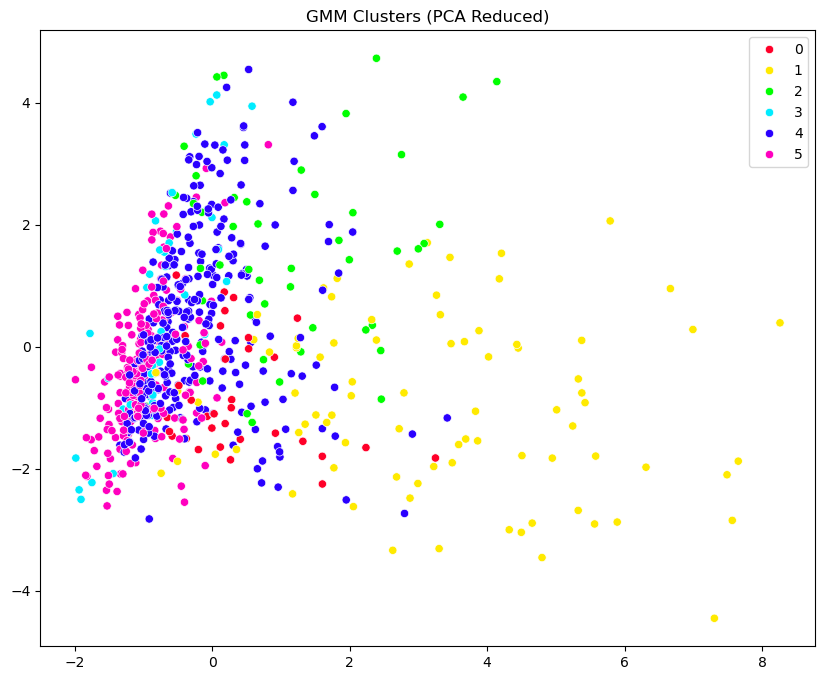

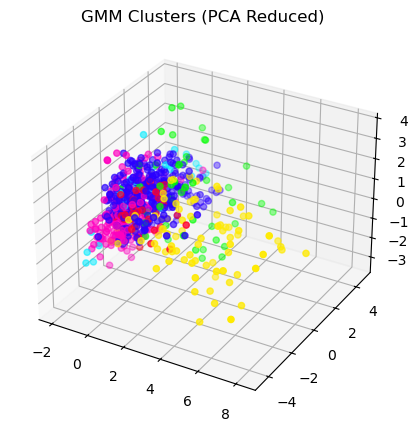

In [40]:

# Visualize clusters using PCA (2D)
spotify_gmm_pca = PCA(n_components=2)
X_pca = spotify_gmm_pca.fit_transform(X_train_spotify)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=gmm_labels, palette='gist_rainbow')
plt.title('GMM Clusters (PCA Reduced)')
plt.show()

# Visualize clusters using PCA (3D)
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_train_spotify)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=gmm_labels, cmap='gist_rainbow')
ax.set_title('GMM Clusters (PCA Reduced)')

plt.show()

In [41]:
# # spotify_feature_names = X_train_spotify.columns.tolist()
# n_features = X_train_spotify.shape[1]  # Get number of features
# spotify_feature_names = [f'Feature_{i+1}' for i in range(n_features)]


In [42]:
spotify_feature_names = spotify_features_encoded.columns.tolist()


In [43]:
print(f'Feature Names: {spotify_feature_names}')

Feature Names: ['bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'in_spotify_playlists', 'in_deezer_playlists', 'in_apple_playlists', 'artist_count', 'released_year']


In [44]:
# Get the components (eigenvectors)
components = pd.DataFrame(
    spotify_gmm_pca.components_,
    columns=spotify_feature_names,
    index=['PC1', 'PC2']
)

# Get explained variance ratio
explained_variance = spotify_gmm_pca.explained_variance_ratio_

# Print results
print("Principal Components (feature contributions):")
print(components)
print("\nExplained variance ratio:")
print(explained_variance)

# Create a more detailed breakdown of feature importance
feature_importance = pd.DataFrame()
for i, (component, variance) in enumerate(zip(spotify_gmm_pca.components_, explained_variance)):
    # Get absolute coefficients for this component
    abs_coefficients = np.abs(component)
    # Calculate relative importance considering the variance explained
    importance = abs_coefficients * variance
    # Store in dataframe
    feature_importance[f'PC{i+1}'] = importance

feature_importance.index = spotify_feature_names
print("\nFeature importance (weighted by explained variance):")
print(feature_importance)

# Sort features by their importance to PC1
print("\nFeatures sorted by importance to PC1:")
pc1_importance = pd.DataFrame({
    'Feature': spotify_feature_names,
    'Contribution': np.abs(spotify_gmm_pca.components_[0])
})
print(pc1_importance.sort_values('Contribution', ascending=False))

Principal Components (feature contributions):
          bpm  danceability_%  valence_%  energy_%  acousticness_%  \
PC1  0.008340       -0.184218  -0.085087 -0.087967        0.051828   
PC2 -0.014078       -0.399559  -0.407485 -0.523695        0.457714   

     instrumentalness_%  liveness_%  speechiness_%  in_spotify_playlists  \
PC1           -0.002213   -0.040767      -0.146575              0.573660   
PC2            0.171732   -0.086144      -0.113503             -0.157883   

     in_deezer_playlists  in_apple_playlists  artist_count  released_year  
PC1             0.501092            0.454598     -0.130407      -0.348331  
PC2            -0.153429           -0.189614     -0.224193      -0.076640  

Explained variance ratio:
[0.19836024 0.16432602]

Feature importance (weighted by explained variance):
                           PC1       PC2
bpm                   0.001654  0.002313
danceability_%        0.036542  0.065658
valence_%             0.016878  0.066960
energy_%         